# Check Motor Imagery Decoder
Use this clean notebook to check how the MI decoder is working... seems to always be guessing one direction.

Nile Wilson 2019.01.24,28

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
import numpy as np
import pandas as pd
import datetime
import pickle
import csv
import mne

## Function Definitions

In [2]:
def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

In [3]:
def LoadBehavioralDataBCI(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    
    return behavioralData

In [4]:
def SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]

        # Number of trials is greater than number of total pulses sent
        # 999 when the task ends
        move_left_starts = np.where(EEGdata['STI 014'] == 1)[0]
        move_right_starts = np.where(EEGdata['STI 014'] == 2)[0]
        rest_starts = np.where(EEGdata['STI 014'] == 3)[0]
        rest_ends = np.where(EEGdata['STI 014'] == 4)[0]

        num_of_trials = len(rest_starts)
        num_of_movements = len(move_left_starts) + len(move_right_starts)
    
    return num_of_trials, num_of_movements, move_left_starts, move_right_starts, rest_starts, rest_ends

In [5]:
def EpochBCIData(EEGdata, move_left_starts, move_right_starts, rest_starts, rest_ends):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:7]

    epochs = []
    epochs_norm = []
    move_starts = np.sort(np.concatenate((move_left_starts,move_right_starts),0))

    for movement in range(0,len(move_starts)):
        # Data for this movement
        t_start = move_starts[movement] - np.round(1.00*fs)
        t_end = move_starts[movement] - np.round(0.250*fs)

        # Baseline
        restOfInt = np.max(np.where(rest_starts < move_starts[movement]))
        tb_start = rest_starts[restOfInt]
        tb_end = rest_ends[restOfInt]

        baseline = EEGdata.loc[tb_start:tb_end][channels]

        # Store epoch
        tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
        epochs_norm.append(tmp)
        epochs.append(EEGdata.loc[t_start:t_end][channels])

    return epochs, epochs_norm

In [6]:
def OrganizeTrials(behavioralData):
    """
    Organizes trials
    """
    
    # When target was to the left
    trialL = np.where(behavioralData['target_x'] < behavioralData['player_x'])
    
    # When target was to the right
    trialR = np.where(behavioralData['target_x'] > behavioralData['player_x'])
    
    # Create a single list that includes which trial is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1

    trial_type = np.round(trial_type[0])

    return trial_type, trialL, trialR

In [7]:
def ExtractFeaturesBCI(epochs, num_of_movements, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for movement in range(0, num_of_movements):
            f, Pxx_den = signal.welch(signal.decimate(epochs[movement][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) > 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) > 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

In [8]:
def TrainDecoder(X, y):
    """
    Trains the decoder on ALL the data (does not split into test and train because this is all train)
    """
    # preprocess dataset, split into training and test part
    args = np.arange(len(X))
    np.random.shuffle(args)
    X = [X[i] for i in args]
    y = [y[i] for i in args]
    X = StandardScaler().fit_transform(X)
    

    # Determine model parameters
    activations = ['relu','tanh']
    alphas = np.logspace(-6, 3, 10)
    solvers = ['lbfgs','sgd']
    hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
    grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)
    grid.fit(X, y)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X,y)
    
    """
    # Split into train and test for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    grid.fit(X_train, y_train)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    print(grid.best_estimator_)
    print('-----------')
    print('score: ' + str(score))
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('-----------')
    """
    
    return clf, X, y

## Variables to Set

In [9]:
subjID = 'nile'
EEGdevice = 8 # 7 for DSI-7, 8 for Enobio
filename_eeg = '../data/Enobio/20190125144918_Nile_BCI.easy'
filename_behavioral = '../data/Enobio/BCI_nile_R36.csv'

## Code to Run

### Run automatically

In [10]:
# Load EEG data
EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

# Load behavioral data
behavioralData = LoadBehavioralDataBCI(filename_behavioral)

# Sync up trigger pulses
num_of_trials, num_of_movements, move_left_starts, move_right_starts, rest_starts, rest_ends = SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData)

# Clean the data
EEGdata_orig = EEGdata.copy()
lf = 1
hf = 40

if EEGdevice == 7:
    channels = EEGdata.columns[1:8]
elif EEGdevice == 8:
    channels = EEGdata.columns[0:7]

# Format our data into an mne-friendly format
ch_types = ['eeg']*len(channels)
info = mne.create_info(ch_names=list(channels), sfreq=fs, ch_types=ch_types)
rawData = EEGdata[channels].values
rawData = np.transpose(rawData)
raw = mne.io.array.RawArray(rawData, info)
raw.set_montage(mne.channels.read_montage(kind='standard_1020'))
raw.filter(l_freq=lf, h_freq=hf)

# Make a copy of the original data just in case
EEGdata[channels] = raw.get_data().T

# Epoch the data
epochs, epochs_norm = EpochBCIData(EEGdata, move_left_starts, move_right_starts, rest_starts, rest_ends)

# Organize trial types
trial_type, trialL, trialR = OrganizeTrials(behavioralData)

# Get signal features
alpha_power, beta_power = ExtractFeaturesBCI(epochs_norm, num_of_movements, ['C3','C4'], 1)
motor_features = [alpha_power['C3'], alpha_power['C4'], beta_power['C3'], beta_power['C4']]
motor_features = np.transpose(motor_features)

Skipping N/A
Creating RawArray with float64 data, n_channels=7, n_times=36504
    Range : 0 ... 36503 =      0.000 ...    73.006 secs
Ready.
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


## Test the BCI data with the loaded MI classifier
This is the Motor Imagery classifier that was created using the Motor Screening data, and was used while the BCI was online

In [244]:
# Load latest model and its associated data
model_file = '../data/Enobio/nile_MI_classifier_2019-01-28-15-14-21.sav' # load the most recent model
loaded_model = pickle.load(open(model_file, 'rb'))

models_data = '../data/Enobio/nile_data_for_MI_classifier_2019-01-28-15-14-21.npz' # load the most recent model
loaded_data = np.load(models_data)
X_loaded = loaded_data['X']
X_loaded_not_scaled = loaded_data['X_not_scaled']
y_loaded = loaded_data['y']

In [12]:
# Scale the BCI motor features prior to classification
# (this is done online as well)
X = StandardScaler().fit_transform(motor_features)

In [21]:
# Look at the motor features in the BCI
print('A single example (one movement)')
print('BCI features: ' + str(motor_features[0]))
print('BCI features (scaled): ' + str(X[0]))

A single example (one movement)
BCI features: [0.0854196  0.01179012 0.4530293  0.04262396]
BCI features (scaled): [-0.35032311 -0.19251599  0.67060625 -0.04637718]


Okay, so this actually looks fine in this notebook... The values of the BCI features are similar to that of the features used in training the classifier.

However, when I'm running the task online, it only ever classifies the epochs as indicating right motor imagery and thus always move the cursor to the right.

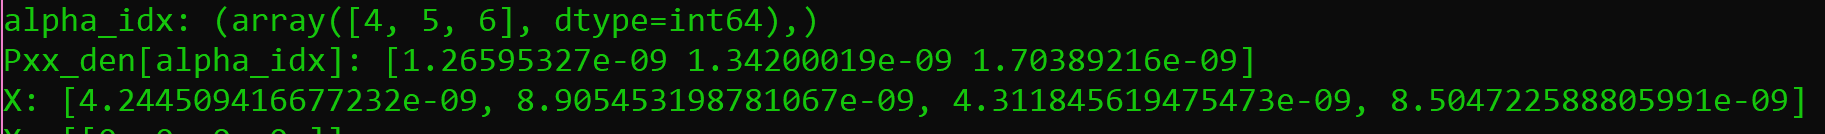

For example, looking at the above screenshot, we see that the values for our features, X, are really low. Instead of what we see here in this notebook around 0.08, 0.01, 0.45 etc, we see values in 4e-09.

In [14]:
# Look at the motor features used in training the decoder
print('A single example used for training (not in BCI)')
print('MI training features: ' + str(X_loaded[0]))

A single example used for training (not in BCI)
MI training features: [ 0.41480967 -0.14220343 -0.5599812   0.04194751]


In [15]:
# Test BCI data against loaded MI classifier
clf = loaded_model
clf.predict(motor_features)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1])

In [16]:
print('Score: ' + str(clf.score(X, trial_type)))
print(confusion_matrix(trial_type, clf.predict(X)))

Score: 0.46808510638297873
[[18 17]
 [ 8  4]]


## Further Investigation
So it looks like there must be some problem in how we are calculating the features online in the BCI script. Let's compare values at different stages between what's printed live and what's recorded.

(Note: the loaded data here is from a different run that what is shown in the screenshot below, but the info in the screenshot is comparable to what was online with this loaded data)

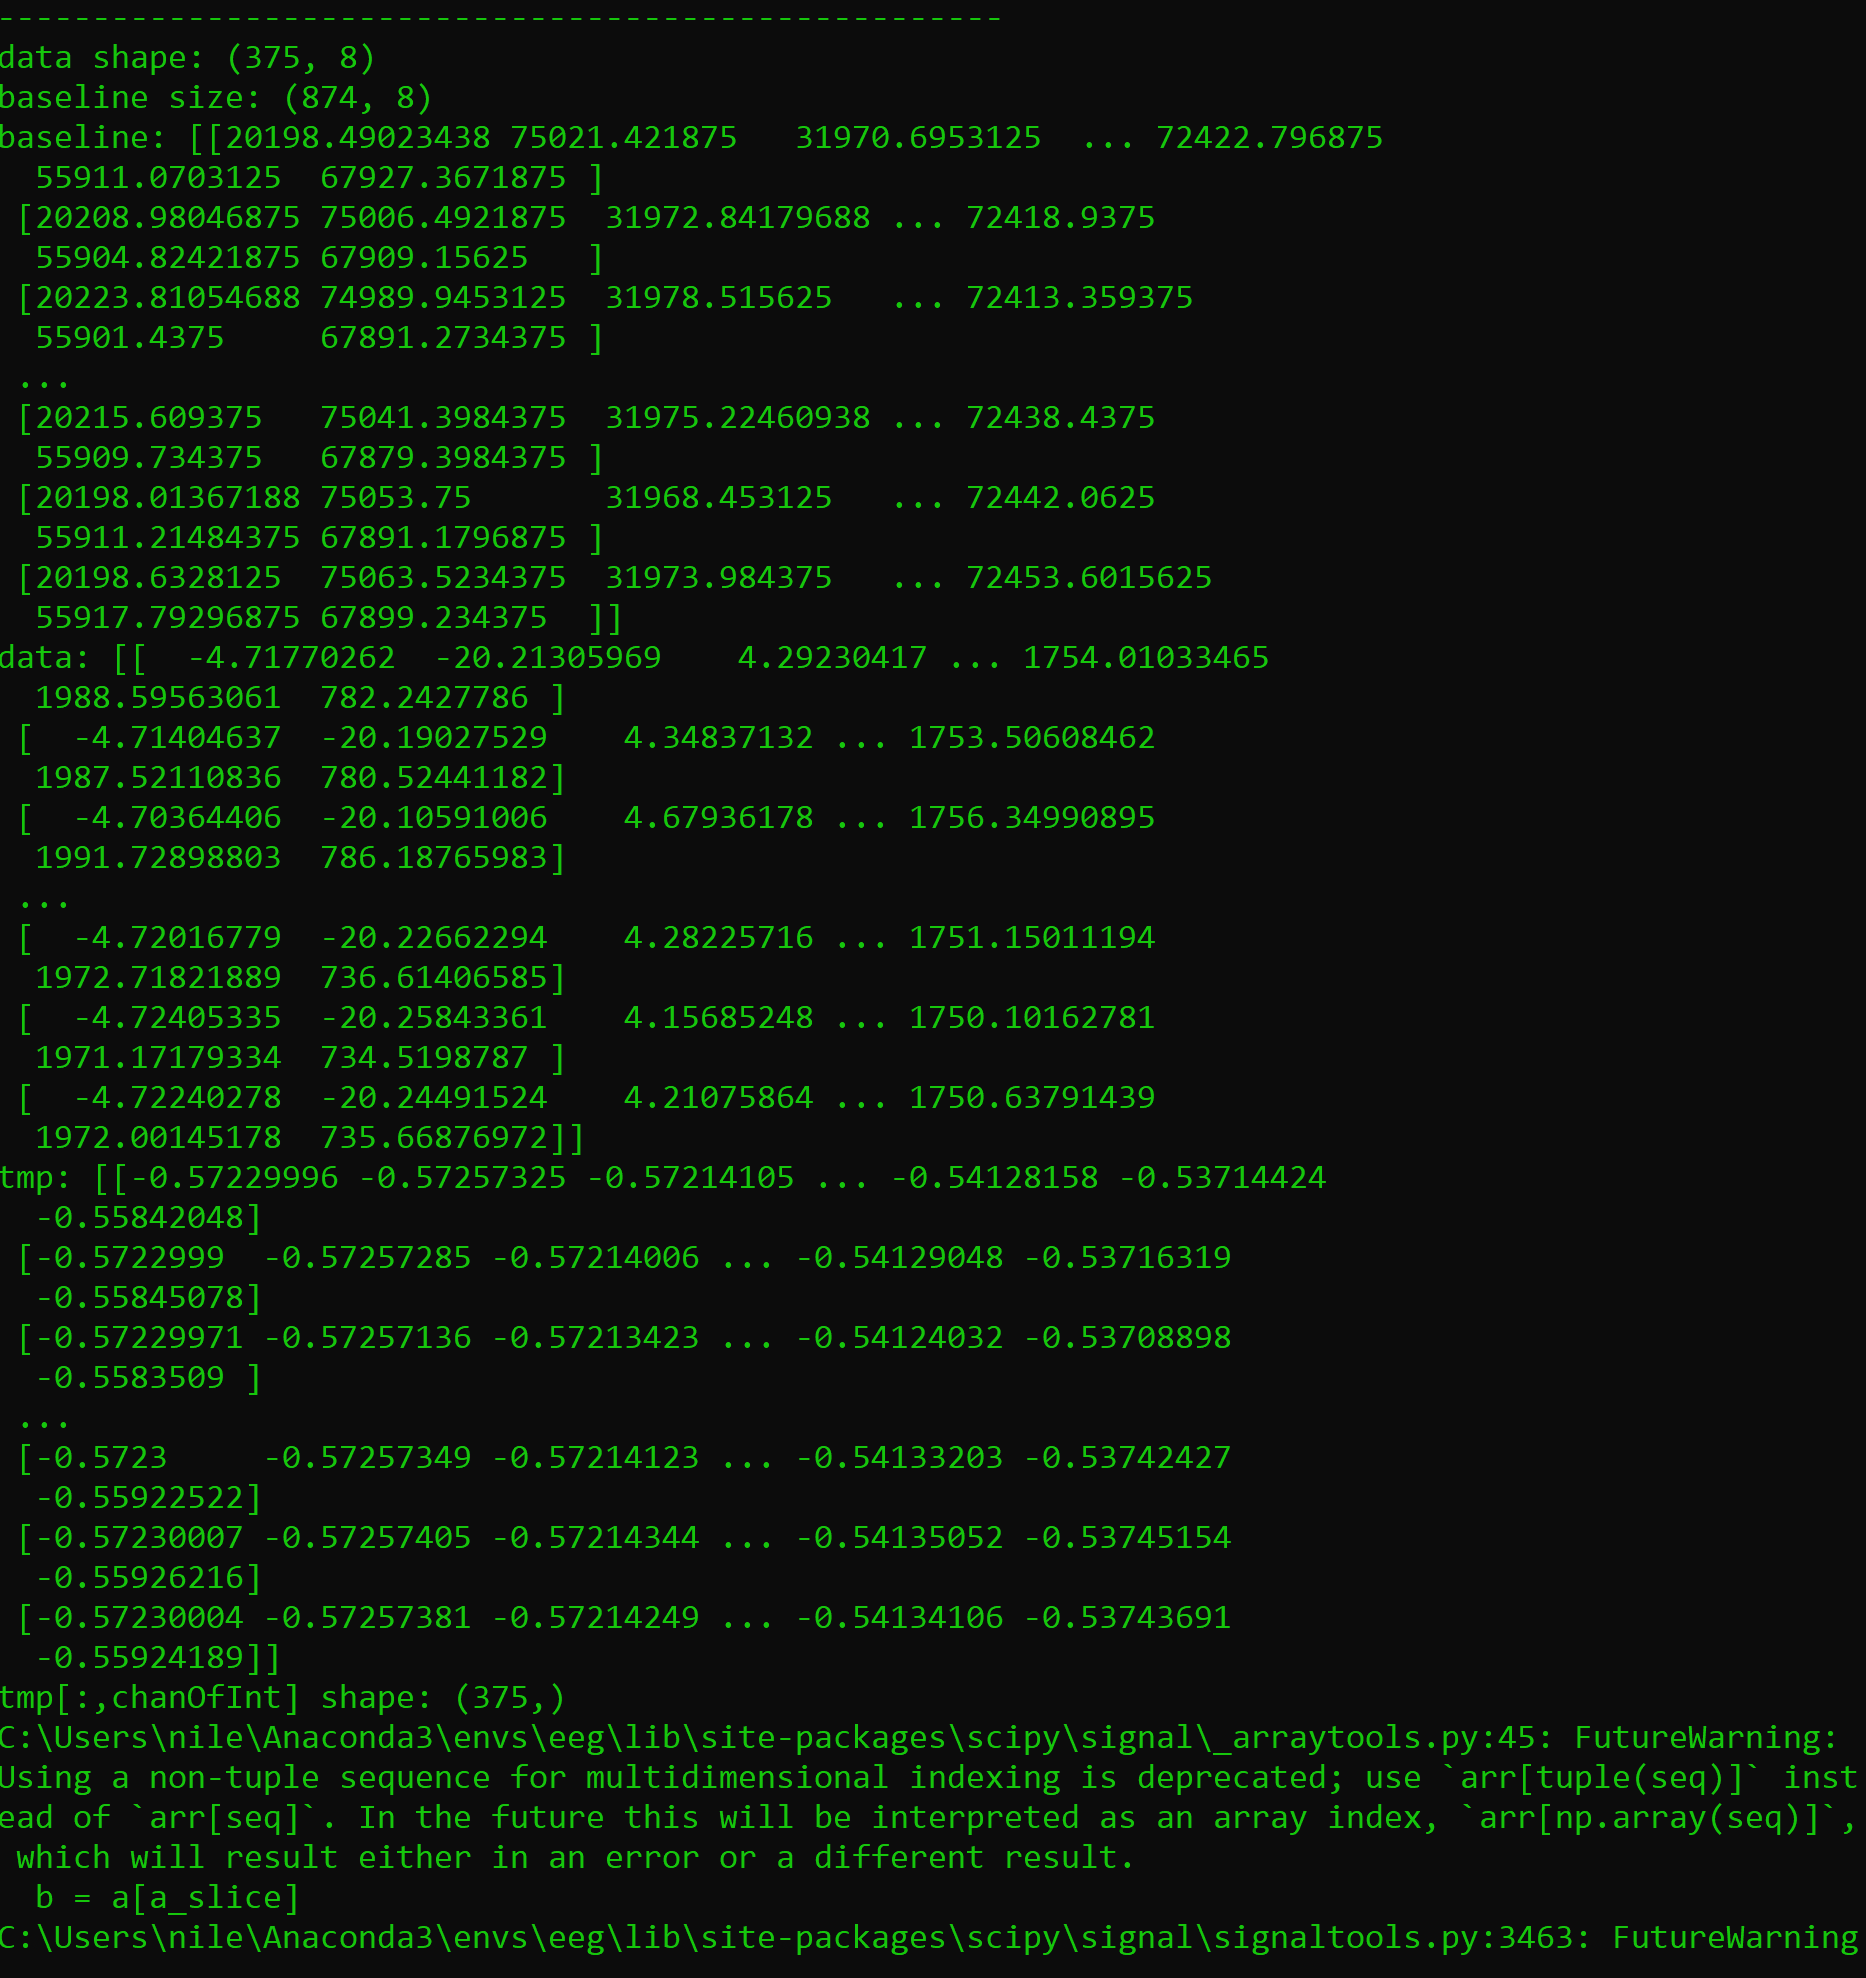

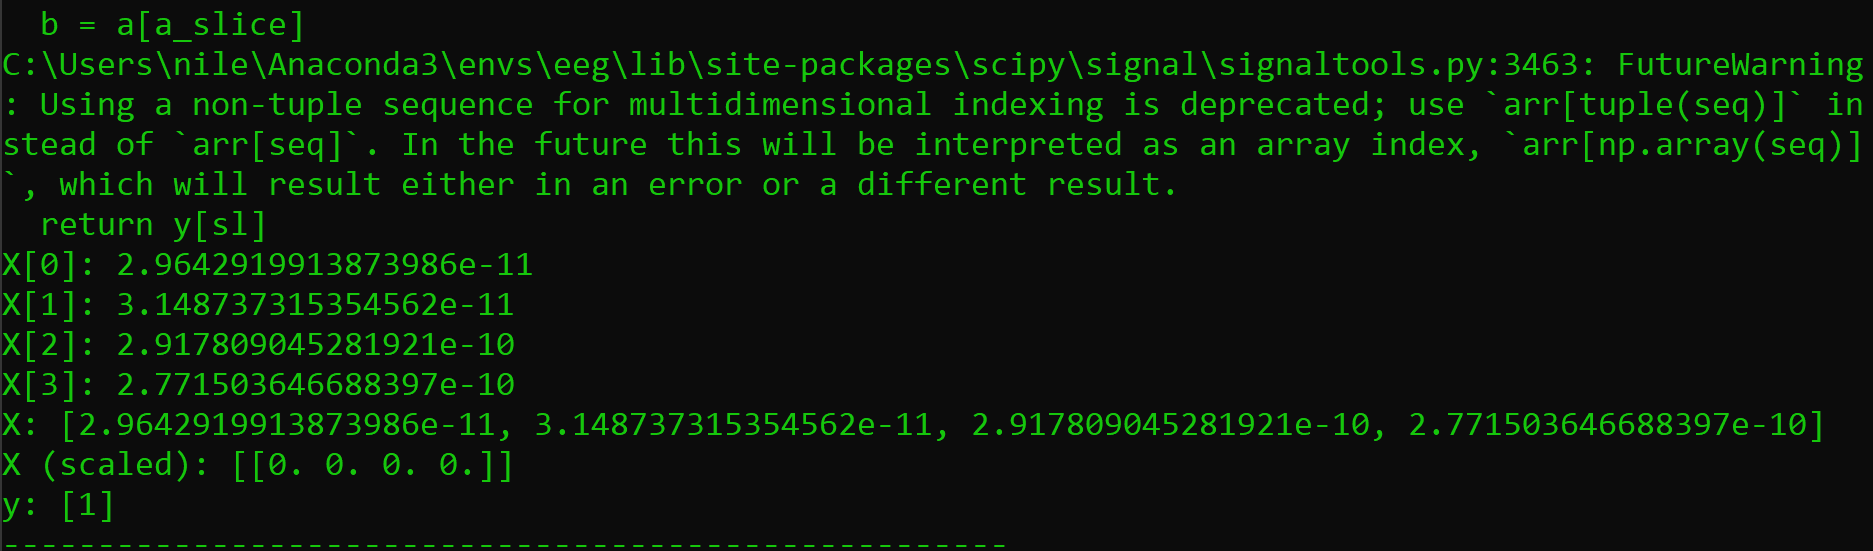

Let's look at a single baseline example

In [22]:
if EEGdevice == 7:
    channels = EEGdata.columns[1:8]
elif EEGdevice == 8:
    channels = EEGdata.columns[0:7]

epochs = []
epochs_norm = []
baseline = []
move_starts = np.sort(np.concatenate((move_left_starts,move_right_starts),0))

for movement in range(0,len(move_starts)):
    # Data for this movement
    t_start = move_starts[movement] - np.round(1.00*fs)
    t_end = move_starts[movement] - np.round(0.250*fs)

    # Baseline
    restOfInt = np.max(np.where(rest_starts < move_starts[movement]))
    tb_start = rest_starts[restOfInt]
    tb_end = rest_ends[restOfInt]

    tmp_baseline = EEGdata.loc[tb_start:tb_end][channels]

    # Store epoch
    tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(tmp_baseline))/np.std(tmp_baseline)
    epochs_norm.append(tmp)
    epochs.append(EEGdata.loc[t_start:t_end][channels])
    baseline.append(tmp_baseline)

In [32]:
movementOfInt = 14
baseline[movementOfInt].head()

,F3,Fz,F4,FCz,C3,Cz,C4
9455,-1.232811e-08,1925.397094,-24370.708188,-15979.830096,-14369.368603,-15387.594395,-7452.996090
9456,-1.720208e-08,92.971998,-25995.078652,-17728.915090,-16225.341161,-16835.394376,-9017.305913
9457,-2.443985e-08,-460.834953,-26575.100099,-18401.390585,-16964.476034,-17211.654415,-9610.549485
9458,-1.363388e-08,303.152507,-26045.710137,-17919.344340,-16513.010554,-16439.791447,-9152.693701
9459,-2.463268e-08,2184.531328,-24549.559985,-16412.782238,-15004.175436,-14638.414086,-7745.143444


Just looking at this, it seems like the baseline is about of the same scale. In the screenshot, we see values usually in the 10,000s range (positive or negative). The values in the loaded data here are a bit lower in some channels, but seems to be in that 10,000s magnitude for the most part.

In [33]:
np.shape(baseline[movementOfInt])

(505, 7)

The shape is also generally the same. The length should vary from 500-1000 samples in length, as the ITI ranges from 1-2 seconds.

Now let's look at the actual data, pre-normalization to baseline. In the screenshot, this is shown as the variable `data`

In [35]:
epochs[movementOfInt].head()

,F3,Fz,F4,FCz,C3,Cz,C4
13482,-7.590279e-08,-126906.168671,6631.312218,17504.785935,-1783.370984,21847.045358,28332.814707
13483,-5.960464e-08,-125139.662380,9913.820537,20158.720196,1073.015559,25103.817519,30315.729278
13484,-5.587935e-08,-123167.659759,13588.497004,23157.437155,4334.901790,28472.962108,32737.608872
13485,-5.774200e-08,-121532.859878,17136.677274,25983.387761,7470.796190,31418.414742,35127.049380
13486,-1.396984e-08,-120742.276948,20055.676828,28134.195324,9958.808475,33469.609710,36997.306202


Interesting... so in the table above, we see that the epochs are of a similar scale of the baseline, as expected. But in the screenshot, the values of `data` are much smaller (on the scale of 1s, 10s, 100s, and sometimes 1,000s).

Understandably, if we normalize to baseline with such small values, the normalized values (stored in `tmp` in the screenshot) will be very low. But the values will appear as expected with the preloaded data here (see below).

In [36]:
epochs_norm[movementOfInt].head()

,F3,Fz,F4,FCz,C3,Cz,C4
13482,-3.021080,-8.386379,0.706964,1.264259,-0.233614,1.736451,1.667159
13483,-2.088835,-8.268830,0.976109,1.545746,0.267059,2.017391,1.761336
13484,-1.875750,-8.137607,1.277408,1.863801,0.838809,2.308025,1.876362
13485,-1.982293,-8.028822,1.568336,2.163533,1.388475,2.562110,1.989847
13486,0.521451,-7.976214,1.807675,2.391656,1.824579,2.739052,2.078674


Because the issue lies in how the epoch data is being stored in the BCI code, let's try storing it a different way. Previously, the EEG data was buffered into a variable called `data` which was then passed into the `classify_epoch()` function, but let's now try having a class variable named `eeg_data` which we pass this data into instead.

Okay, that didn't make a difference.

It looks like running a butter bandpass filter on the short 750 ms of data online was reducing the values significantly from the 10,000s range to the 1-1,000 range. But even after commenting out the filtering, we still end up with very small features values, even though our `tmp` value now looks more similar to `epochs_norm` in scale.

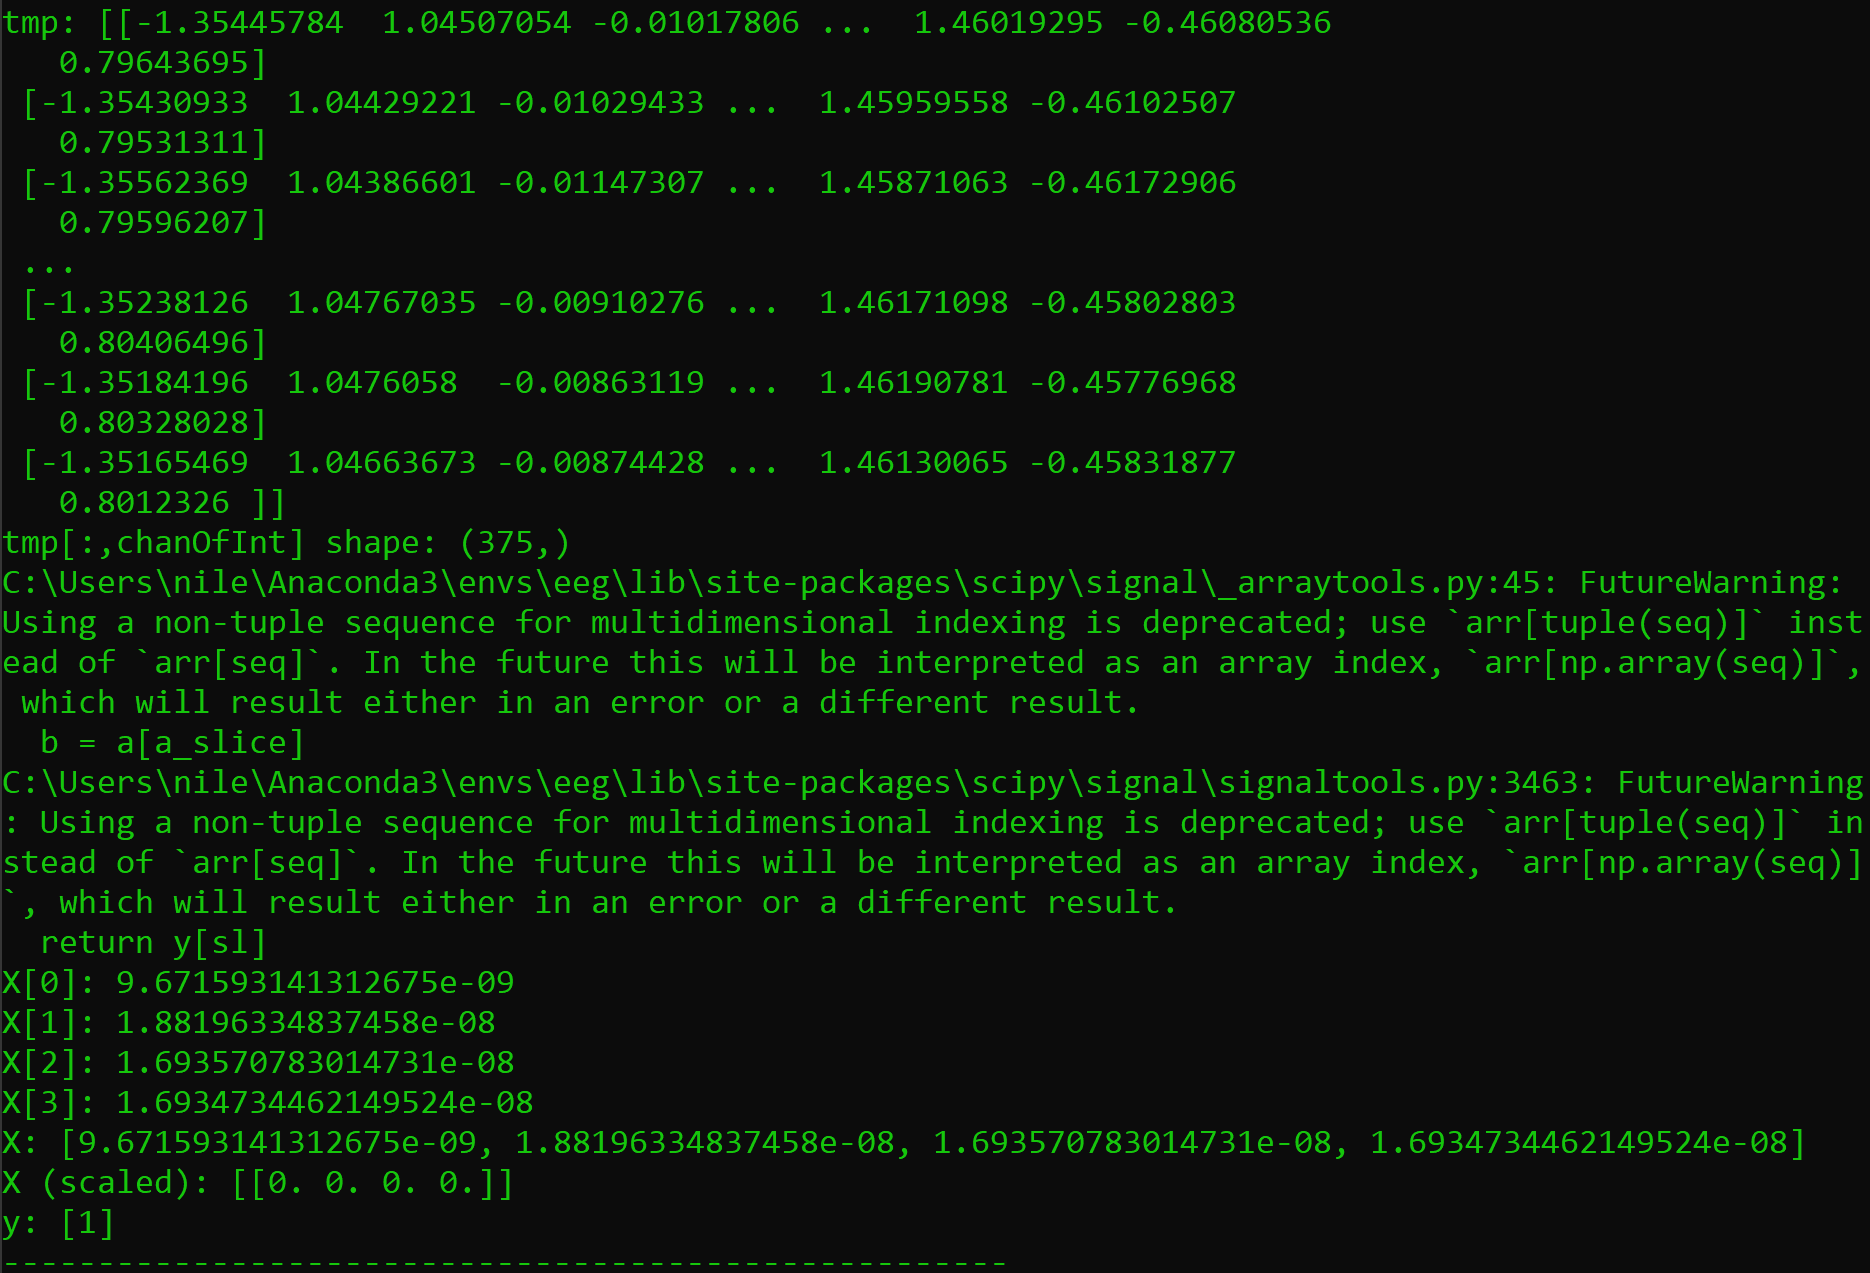

Let's look at a single example without filtering the data here

In [37]:
# Epoch the data
epochs_noFilt, epochs_norm_noFilt = EpochBCIData(EEGdata_orig, move_left_starts, move_right_starts, rest_starts, rest_ends)

In [38]:
epochs_noFilt[movementOfInt].head()

,F3,Fz,F4,FCz,C3,Cz,C4
13482,-400000047,59833676,25223735,51800400,-74416455,73521432,21667053
13483,-400000047,59835250,25236895,51803785,-74410971,73508748,21672537
13484,-400000047,59839875,25245717,51806074,-74406728,73505219,21677448
13485,-400000047,59845025,25245335,51806265,-74410924,73512515,21678736
13486,-400000047,59849460,25236275,51802736,-74421176,73528298,21673968


In [39]:
epochs_norm_noFilt[movementOfInt].head()

,F3,Fz,F4,FCz,C3,Cz,C4
13482,NaN,-139.545817,14.493107,17.975779,-25.912801,8.648886,32.230804
13483,NaN,-139.476152,14.758357,18.107390,-25.905490,8.139241,32.417666
13484,NaN,-139.271450,14.936172,18.196388,-25.899833,7.997445,32.585004
13485,NaN,-139.043511,14.928472,18.203814,-25.905427,8.290599,32.628891
13486,NaN,-138.847217,14.745861,18.066604,-25.919096,8.924763,32.466426


In [59]:
# Get features for no filter and normalized no filter epochs
alpha_power_noFilt, beta_power_noFilt = ExtractFeaturesBCI(epochs_noFilt, num_of_movements, ['C3','C4'], 1)
alpha_power_norm_noFilt, beta_power_norm_noFilt = ExtractFeaturesBCI(epochs_norm_noFilt, num_of_movements, ['C3','C4'], 1)

In [61]:
print('Alpha noFilt: ' + str(alpha_power_noFilt['C3'][movementOfInt]))
print('Alpha noFilt normalized: ' + str(alpha_power_norm_noFilt['C3'][movementOfInt]))

print('Beta noFilt: ' + str(beta_power_noFilt['C3'][movementOfInt]))
print('Beta noFilt normalized: ' + str(beta_power_norm_noFilt['C3'][movementOfInt]))

Alpha noFilt: 23269500.115459263
Alpha noFilt normalized: 4.136141885108526e-05
Beta noFilt: 10049832.527498577
Beta noFilt normalized: 1.7863526525744433e-05


In [62]:
# Get features for with filter
alpha_power_filt, beta_power_filt = ExtractFeaturesBCI(epochs, num_of_movements, ['C3','C4'], 1)
alpha_power_norm_filt, beta_power_norm_filt = ExtractFeaturesBCI(epochs_norm, num_of_movements, ['C3','C4'], 1)

In [64]:
print('Alpha filtered: ' + str(alpha_power_filt['C3'][movementOfInt]))
print('Alpha filtered normalized: ' + str(alpha_power_norm_filt['C3'][movementOfInt]))

print('Beta filtered: ' + str(beta_power_filt['C3'][movementOfInt]))
print('Beta filtered normalized: ' + str(beta_power_norm_filt['C3'][movementOfInt]))

Alpha filtered: 11637780.480606109
Alpha filtered normalized: 0.3575567047885643
Beta filtered: 9753305.182285432
Beta filtered normalized: 0.2996584845011254


Okay, so the issue is obviously in the filtering. More specifically, the issue is that when we train the classifier and do offline analysis, we filter the full data timeseries at once. But when we are doing online work, we are filtering each 750 ms epoch individually.

Remember that the data being used online is only 750 ms, which is only 375 samples. Filtering something this small could be an issue.

We were filtering using the CCDLUtil custom filter code, but let's switch to `mne.filter.filter_data()` and see what happens.

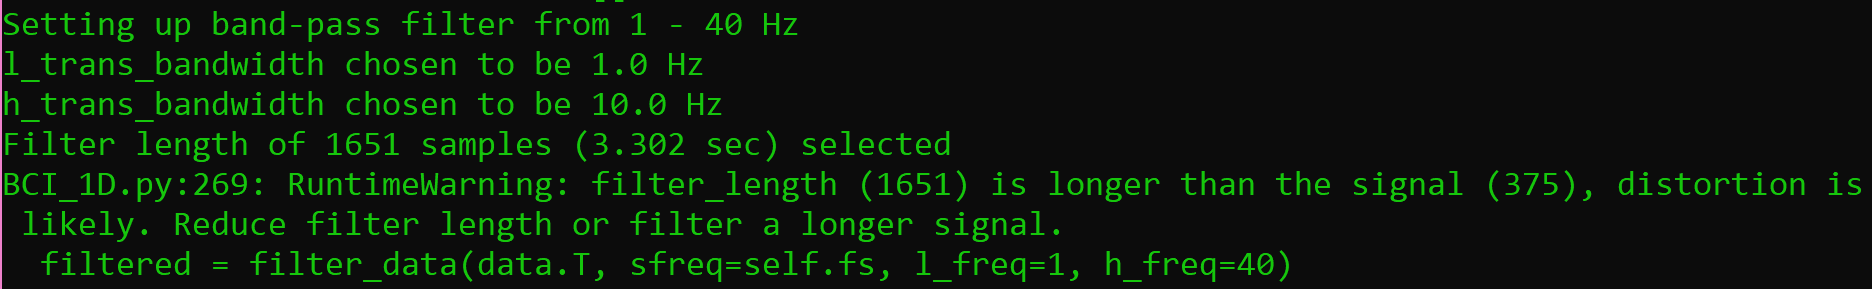

As expected, the MNE filter function gives a warning that the data we are feeding in is too short. Let's play around to see what possible parameters might work to allow for filtering on 750 ms of data.

In [65]:
from mne.filter import filter_data

In [67]:
epochs_noFilt[movementOfInt].head()

,F3,Fz,F4,FCz,C3,Cz,C4
13482,-400000047,59833676,25223735,51800400,-74416455,73521432,21667053
13483,-400000047,59835250,25236895,51803785,-74410971,73508748,21672537
13484,-400000047,59839875,25245717,51806074,-74406728,73505219,21677448
13485,-400000047,59845025,25245335,51806265,-74410924,73512515,21678736
13486,-400000047,59849460,25236275,51802736,-74421176,73528298,21673968


In [107]:
tmp = epochs_noFilt[movementOfInt].values
tmp = tmp * 1.0 # to convert to float
np.shape(tmp)

(376, 7)

In [201]:
tmp_filt = filter_data(tmp.T, sfreq=fs, l_freq=1, h_freq=40)

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


<ipython-input-201-35fe26d55aec>:1: RuntimeWarning: filter_length (1651) is longer than the signal (376), distortion is likely. Reduce filter length or filter a longer signal.
  tmp_filt = filter_data(tmp.T, sfreq=fs, l_freq=1, h_freq=40)


In [121]:
tmp_filt = filter_data(tmp.T, sfreq=fs, l_freq=7, h_freq=31)

Setting up band-pass filter from 7 - 31 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.8 Hz
Filter length of 825 samples (1.650 sec) selected


<ipython-input-121-191a5e5d46ee>:1: RuntimeWarning: filter_length (825) is longer than the signal (376), distortion is likely. Reduce filter length or filter a longer signal.
  tmp_filt = filter_data(tmp.T, sfreq=fs, l_freq=7, h_freq=31)


Let's test using yet another filtering method

In [126]:
tmp = epochs_noFilt[movementOfInt].values
tmp = tmp * 1.0 # to convert to float
np.shape(tmp)

(376, 7)

In [198]:
l_freq = 1
h_freq = 40
nyq = 0.5 * fs
b, a = scisig.butter(4, [l_freq/nyq, h_freq/nyq], btype='band')
#zi = scisig.lfilter_zi(b, a)
#y, zo = scisig.lfilter(b, a, tmp2, zi=zi)
y = scisig.lfilter(b, a, tmp)

No warnings are given, but still not promising. If we reduce the band limits and increase the size of the data buffer, we are able to use the MNE filter without any warnings.

In [223]:
tmp2 = np.random.rand(int(1.75*fs), np.shape(tmp)[1])
np.shape(tmp2)

(875, 7)

In [225]:
tmp_filt = filter_data(tmp2.T, sfreq=fs, l_freq=7, h_freq=31)

Setting up band-pass filter from 7 - 31 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.8 Hz
Filter length of 825 samples (1.650 sec) selected


Okay, now let's look at the values when we run the BCI task using scisig.lfilter on both the baseline and the epoch data.

Nothing changed because the filter wasn't really being applied.

If we switch back to the MNE filtering method, change the low frequency cut off to 7 Hz instead of 1 Hz, and the high frequency cut off to 31 Hz instead of 40 Hz, then we are able to run the filtering on epochs of data that are 1.75 seconds long. So, making changes in the script accordingly to make movements every 2 second instead of every 1 (and using 1750 ms of data to process), we get the following:

(Note, the baseline is also filtered)

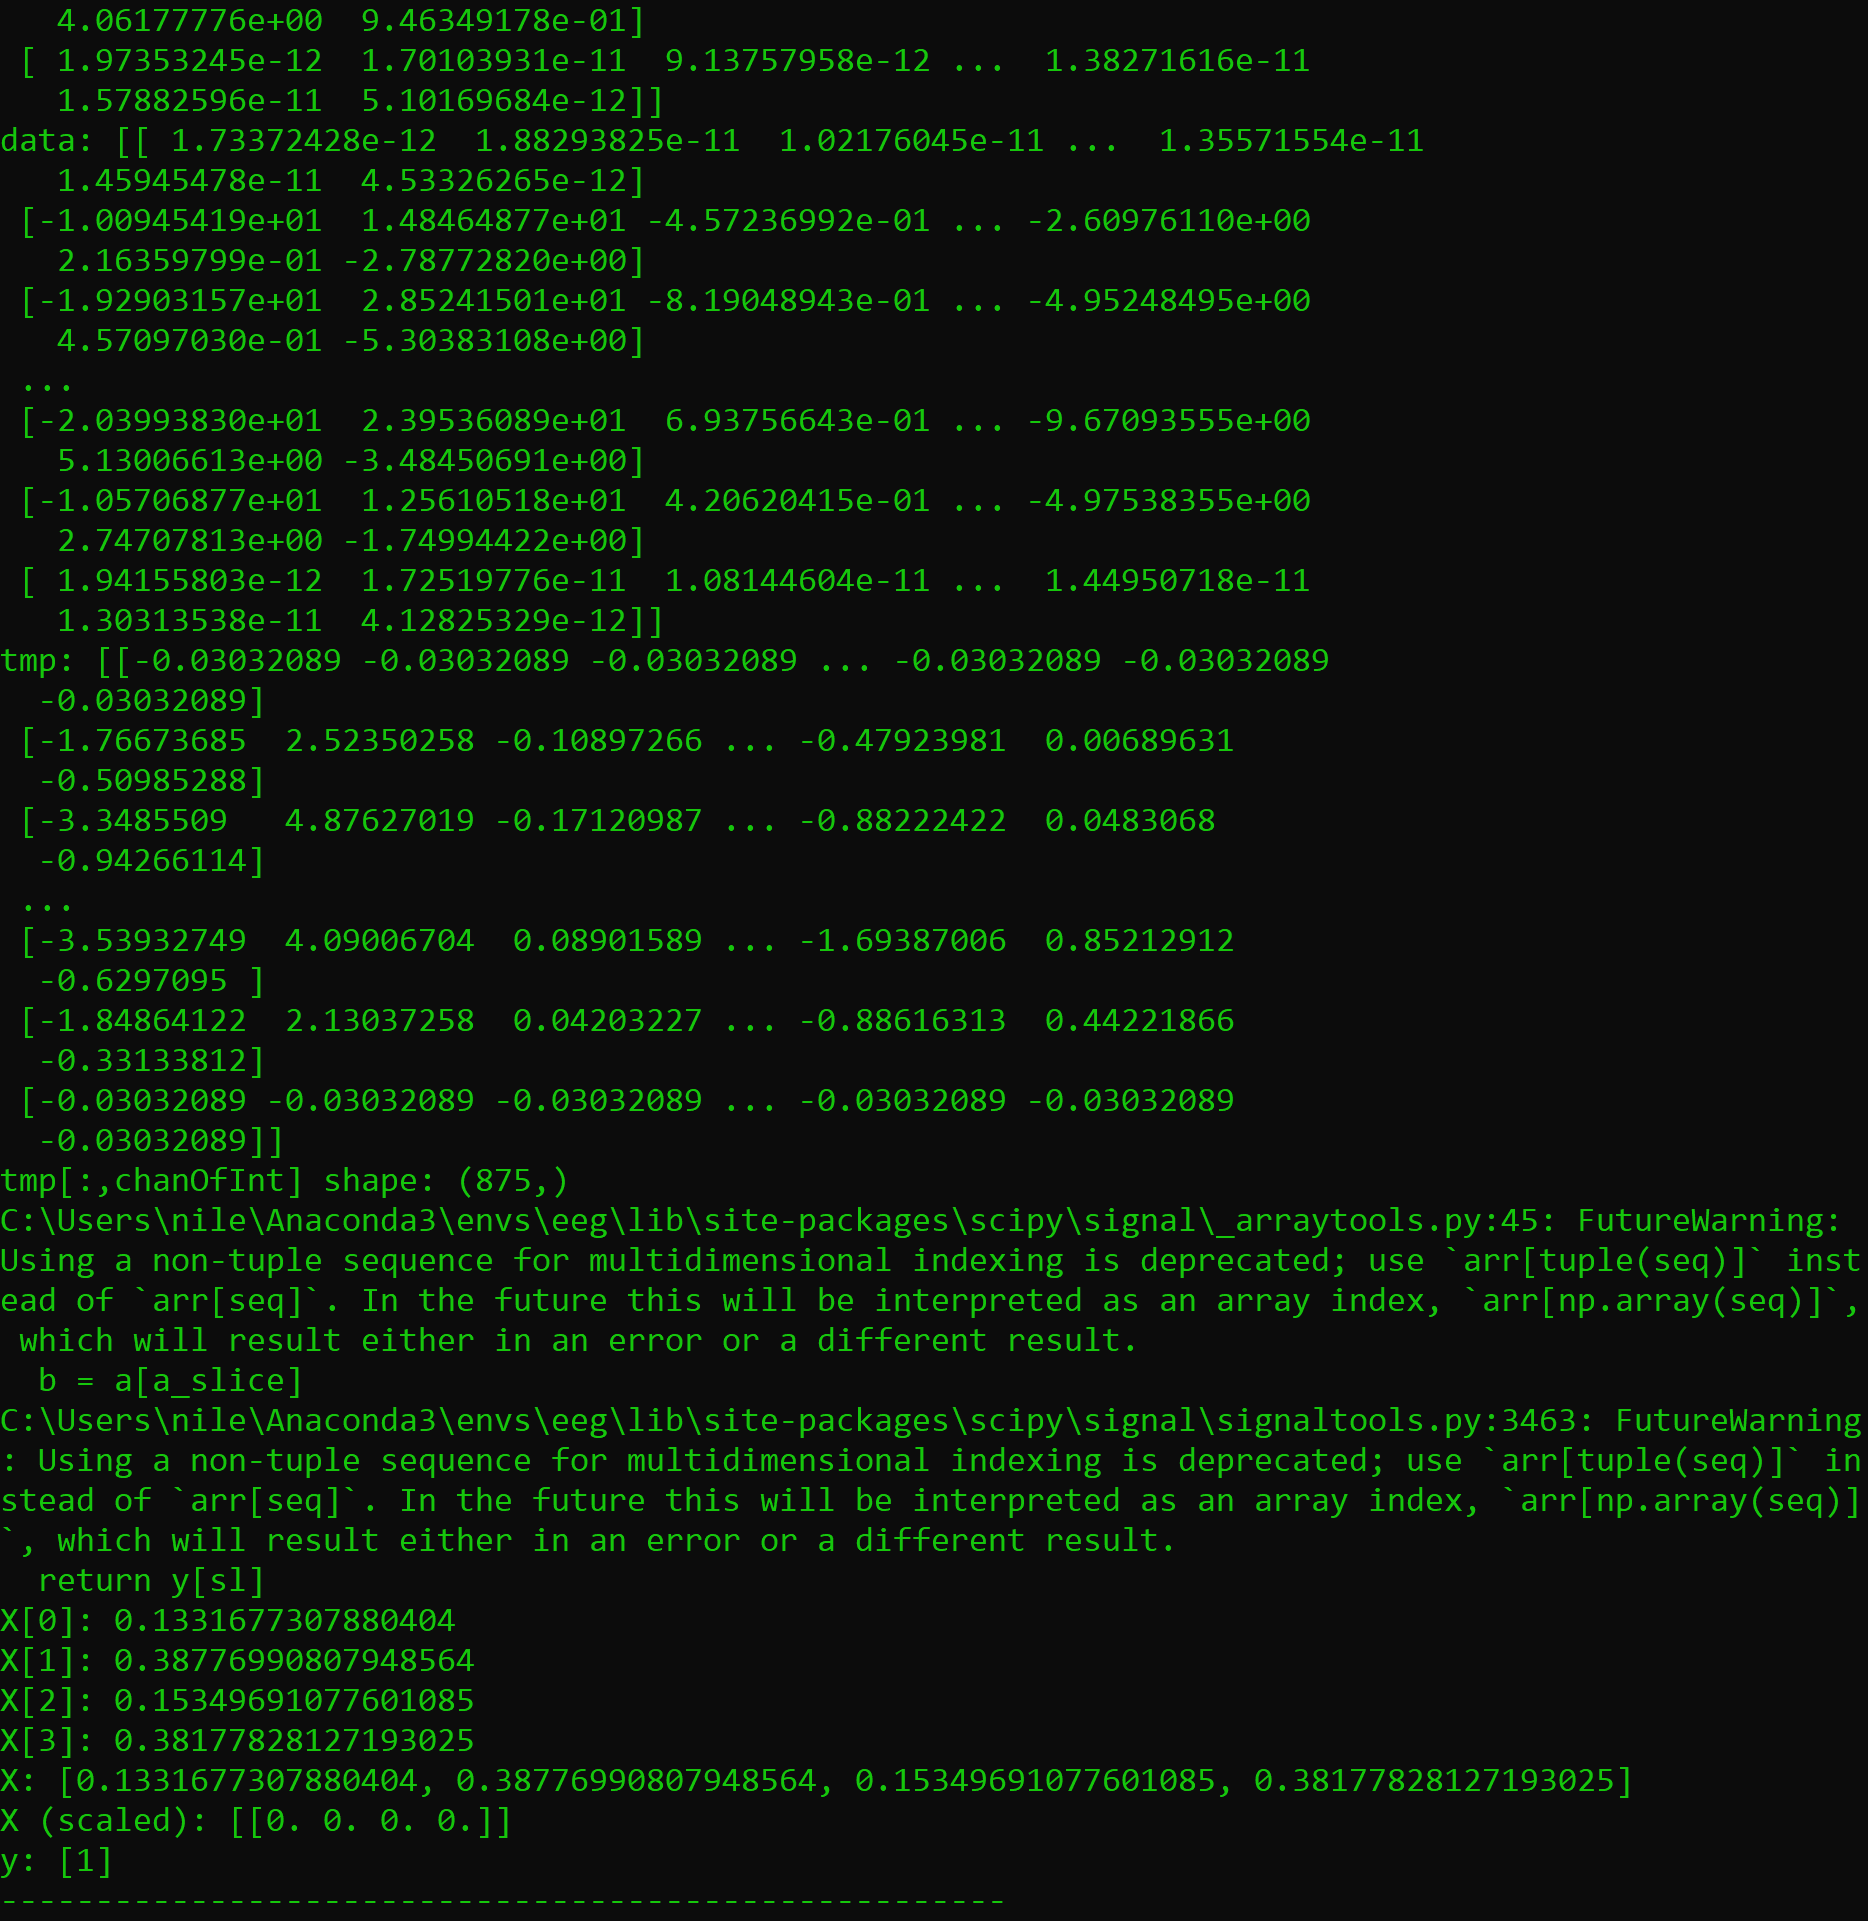

Notice that the feature values are much closer to what we expected! However, when scaled, they are all going to zero, which is not what we want. Let's investigate how doing standard scaling on one example, instead of doing scaling on all examples at once, affects the output.

In [228]:
# Look at a single example using normalized and filtered data
motor_features[0]

array([0.0854196 , 0.01179012, 0.4530293 , 0.04262396])

In [231]:
# Check format that's needed to use only one example in the scaler
motor_features[0].reshape(1,-1)

array([[0.0854196 , 0.01179012, 0.4530293 , 0.04262396]])

In [230]:
# Scale
StandardScaler().fit_transform(motor_features[0].reshape(1,-1))

array([[0., 0., 0., 0.]])

Check values of scaled features when doing all at once

In [237]:
motor_features_scaled = StandardScaler().fit_transform(motor_features)

In [236]:
motor_features_scaled[0]

array([-0.35032311, -0.19251599,  0.67060625, -0.04637718])

Okay, so the issue definitely lies in the standard scaling. The way that standard scaling is applied is that it's just a z-scoring of all the values in X.

So in our BCI code, we can load the X associated with the model that is loaded, and standardize to that, instead of using the scikit-learn built in standard scaler, which does not work well at all for one example (because there is no distribution to calculate mean and standard deviation from).

In [245]:
np.shape(X_loaded_not_scaled)

(990, 4)

In [246]:
np.mean(X_loaded_not_scaled,0)

array([0.09230597, 0.07132962, 0.39009448, 0.18166612])

In [247]:
np.std(X_loaded_not_scaled,0)

array([0.0831387 , 0.06514939, 0.25812769, 0.11729901])

## All Fixed
Yup! After adding in the correct filtering (had to extend data buffering) and correct scaling, the BCI now moves the cursor in more than one direction and appears to work correctly!